In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
%matplotlib inline

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [2]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Missing data

In [3]:
df_null = df_train.isnull().sum()
#print (len(df_null))
df1 = pd.DataFrame()
for idx_num in range(len(df_null)):
    if df_null.values[idx_num] != 0:
        df_temp = pd.DataFrame(index = [df_null.index[idx_num]],data = [df_null.values[idx_num]])
        df1 = df1.append(df_temp)
print (df1)

                 0
LotFrontage    259
Alley         1369
MasVnrType       8
MasVnrArea       8
BsmtQual        37
BsmtCond        37
BsmtExposure    38
BsmtFinType1    37
BsmtFinType2    38
Electrical       1
FireplaceQu    690
GarageType      81
GarageYrBlt     81
GarageFinish    81
GarageQual      81
GarageCond      81
PoolQC        1453
Fence         1179
MiscFeature   1406


In [4]:
# handle the missing data

# Alley : NA means no alley, so change it to 'None'
df_train.loc[:,'Alley'] = df_train.loc[:,'Alley'].fillna('None')
# FireplaceQu : NA means no Fireplace
df_train.loc[:,'FireplaceQu'] = df_train.loc[:,'FireplaceQu'].fillna('None')
# PoolQC : NA means no pool
df_train.loc[:,'PoolQC'] = df_train.loc[:,'PoolQC'].fillna('None')
# Fence : NA means no fence
df_train.loc[:,'Fence'] = df_train.loc[:,'Fence'].fillna('None')
# MiscFeature : NA means no feature, and its MiscVal should be 0
df_train.loc[:,'MiscFeature'] = df_train.loc[:,'MiscFeature'].fillna('None')
## LotFrontage : make it 0 first
df_train.loc[:,'LotFrontage'] = df_train.loc[:,'LotFrontage'].fillna(0)
## MasVnrType : NaN most likely to be None, make it None first
df_train.loc[:,'MasVnrType'] = df_train.loc[:,'MasVnrType'].fillna('None')
## MasVnrArea : NaN is the same with MasVnrType, make it 0 first
df_train.loc[:,'MasVnrArea'] = df_train.loc[:,'MasVnrArea'].fillna(0)
# BsmtQual : NA means no basement 
df_train.loc[:,'BsmtQual'] = df_train.loc[:,'BsmtQual'].fillna('None')
# BsmtCond : NA means no basement
df_train.loc[:,'BsmtCond'] = df_train.loc[:,'BsmtCond'].fillna('None')
# BsmtExposure : NA means no basement, but index 948 is strange, based on other data with unfinished basement, the Nan is mostly 'No'
df_train.loc[948,'BsmtExposure'] = 'No'
df_train.loc[:,'BsmtExposure'] = df_train.loc[:,'BsmtExposure'].fillna('None')
# BsmtFinType1 : NA means no basement
df_train.loc[:,'BsmtFinType1'] = df_train.loc[:,'BsmtFinType1'].fillna('None')
# BsmtFinType2 : NA means no basement
df_train.loc[:,'BsmtFinType2'] = df_train.loc[:,'BsmtFinType2'].fillna('None')
# Electrical : only one NA, and hard to interpret, just drop the data
df_train = df_train[df_train['Electrical'].notnull()]
# GarageType, GarageYrBlt,GarageFinish,GarageQual,GarageCond : NA means no garage
df_train.loc[:,'GarageType'] = df_train.loc[:,'GarageType'].fillna('None')
df_train.loc[:,'GarageFinish'] = df_train.loc[:,'GarageFinish'].fillna('None')
df_train.loc[:,'GarageQual'] = df_train.loc[:,'GarageQual'].fillna('None')
df_train.loc[:,'GarageCond'] = df_train.loc[:,'GarageCond'].fillna('None')
## Tansfer GarageYrBlt later, fill in 0 first, then deal with it 
df_train.loc[:,'GarageYrBlt'] = df_train.loc[:,'GarageYrBlt'].fillna(0)


In [5]:
# handle categorical like feature value
# Survey the data, the features below are categorical type
# MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,
# Condition2,BldgType,HouseStyle,YearBuilt,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,
# ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,Heating
# HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,
# GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

def apply_label_encoder(data,feature_name):
    le.fit(df_train[feature_name])
    data[feature_name] = le.transform(data[feature_name])

labelEncoder_list = ['MSSubClass','MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1',
'Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea',
'Foundation','BsmtFinSF1','Heating','CentralAir','Electrical','GarageYrBlt','Fence','MiscFeature','MoSold','YrSold','SaleType','SaleCondition']
for feature in labelEncoder_list:
    apply_label_encoder(df_train,feature)


def apply_qualify_encoder(data,feature_name):
    return data.replace({feature_name:{"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5}})

qual_labelEncoder_list = ['ExterCond','ExterQual','HeatingQC','KitchenQual','BsmtQual','BsmtCond','FireplaceQu','GarageCond','GarageQual','PoolQC']    
for feature in qual_labelEncoder_list:
    df_train = apply_qualify_encoder(df_train,feature)
    
#special one
df_train = df_train.replace({"BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                  "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                  "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, "ALQ" : 5, "GLQ" : 6},
                  "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                  "Min2" : 6, "Min1" : 7, "Typ" : 8},
                  "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                  "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                  "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                  "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
                  "GarageFinish": {"None" : 0, "Unf":1, "RFn":2,"Fin":3},
                  "GarageType" : {"None":0, "Detchd":1, "CarPort":2, "BuiltIn":3, "Basment":4, "Attchd":5,"2Types":6}})

In [6]:
# drop 'Id', it is no relationship with SalePrice
df_train = df_train.drop('Id',axis=1)

## Correlation

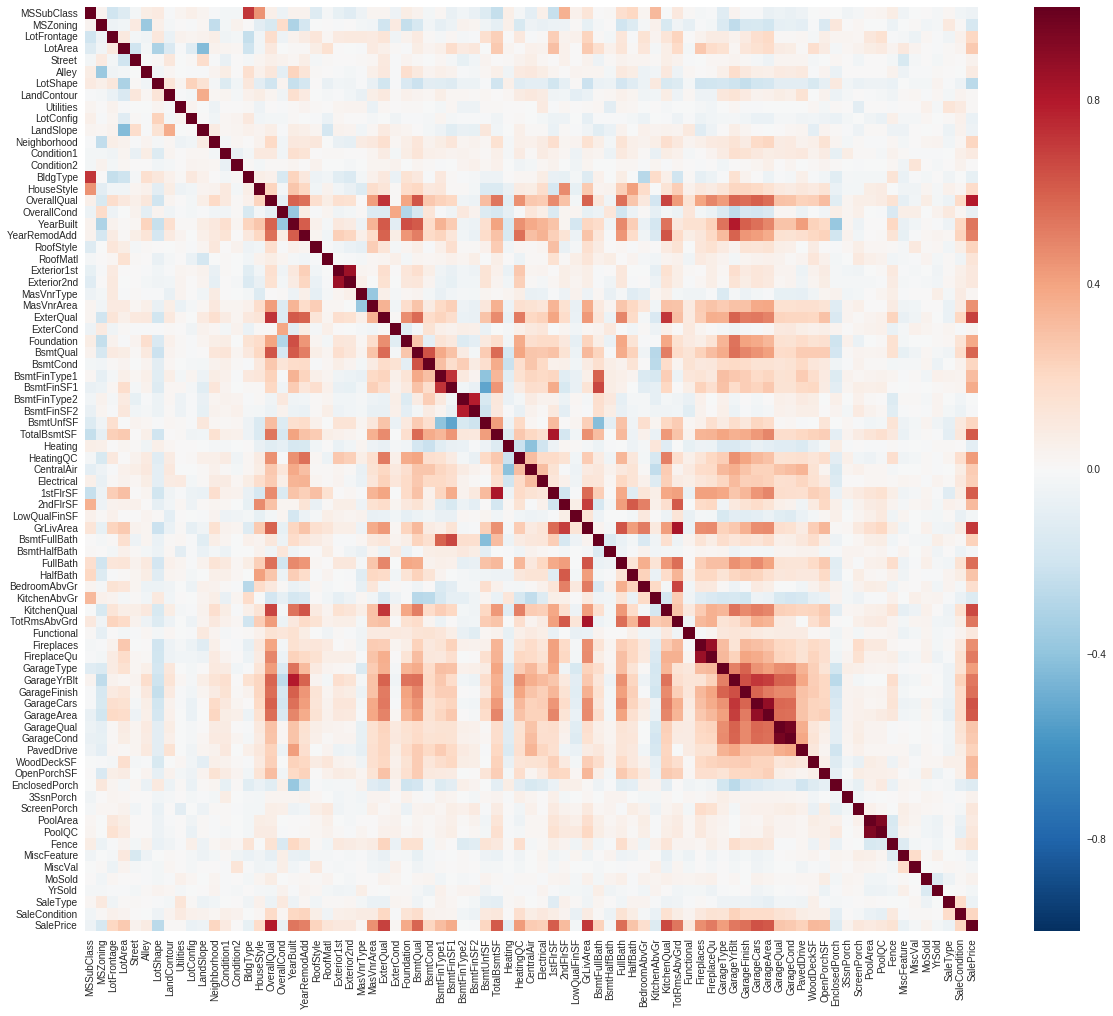

In [7]:
corrmat = df_train.corr()
f,ax = plt.subplots(figsize=(20,17))
sns.heatmap(corrmat)

In [8]:
corrmat.nlargest(len(df_train),'SalePrice')['SalePrice']

SalePrice        1.000000
OverallQual      0.791069
GrLivArea        0.708618
ExterQual        0.682677
KitchenQual      0.659814
GarageCars       0.640473
GarageArea       0.623423
TotalBsmtSF      0.613905
1stFlrSF         0.605968
BsmtQual         0.585349
FullBath         0.560881
GarageFinish     0.549809
YearBuilt        0.535346
TotRmsAbvGrd     0.533779
GarageYrBlt      0.527901
FireplaceQu      0.520507
YearRemodAdd     0.507430
Fireplaces       0.466968
MasVnrArea       0.458195
HeatingQC        0.427639
GarageType       0.415266
Foundation       0.382671
BsmtFinSF1       0.368806
WoodDeckSF       0.324422
2ndFlrSF         0.319464
OpenPorchSF      0.315831
BsmtFinType1     0.304923
HalfBath         0.284400
GarageQual       0.273879
LotArea          0.263837
                   ...   
Exterior1st      0.103658
PoolArea         0.092397
Condition1       0.091152
Alley            0.083125
MoSold           0.046380
3SsnPorch        0.044571
Street           0.041043
ExterCond   

## Outlier 

In [9]:
def outlier_detect(X_feature,y_feature):
    plt.scatter(df_train[X_feature], df_train[y_feature], c = "blue", marker = "s")
    plt.title("Looking for outliers")
    plt.xlabel(X_feature)
    plt.ylabel(y_feature)
    plt.show()

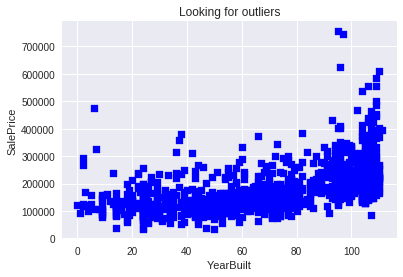

In [10]:
outlier_detect('YearBuilt','SalePrice')
#Change np.log back

In [11]:
df_train[(df_train['YearBuilt']>80) & (df_train['SalePrice']>600000)]
df_train = df_train.drop([691,898,1169,1182])

In [12]:
df_train[(df_train['YearBuilt']<20) & (df_train['SalePrice']>400000)]
df_train = df_train.drop([185])

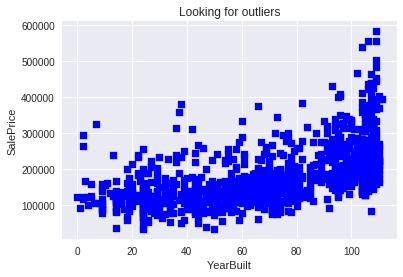

In [13]:
outlier_detect('YearBuilt','SalePrice')

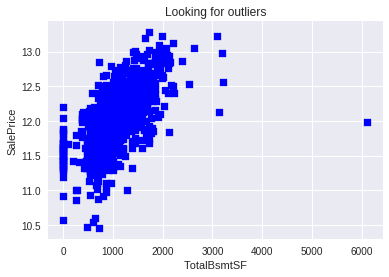

In [39]:
outlier_detect('TotalBsmtSF','SalePrice')

## Feature Selection and transform

Based on the correlation heap map, choose some highly correlated (positive and negative) features to transfrom.

In [15]:
from sklearn import linear_model
from sklearn.model_selection import KFold


def simple_linear_test(train_data,n_fold,feature_list):
    # use n-fold Cross validation 
    kf = KFold(n_fold).split(train_data)
    reg = linear_model.LinearRegression()
    part = 0
    total = 0
    y_train_data = train_data.loc[:,'SalePrice']
    X_train_data = train_data.drop('SalePrice',axis=1).loc[:,feature_list]
    for train_idx,test_idx in kf:
        print("TRAIN:", len(train_idx), "TEST:", len(test_idx))
        X_train, y_train = X_train_data.iloc[train_idx], y_train_data.iloc[train_idx]
        X_test, y_test = X_train_data.iloc[test_idx], y_train_data.iloc[test_idx]
        reg.fit(X_train,y_train)
        pred_test = reg.predict(X_test)
        part += 1
        pred_score = rmse(pred_test,y_test)
        total += pred_score
        print ("%d part RMSE: %.7f" % (part,pred_score))
    print ('Avg RMSE : ',total/n_fold)

In [16]:
# based on previous simple test, do it first is better
df_train['SalePrice'] = np.log(df_train['SalePrice'])

In [17]:
feature_list = ['OverallQual']
simple_linear_test(df_train,10,feature_list)

TRAIN: 1308 TEST: 146
1 part RMSE: 0.3781311
TRAIN: 1308 TEST: 146
2 part RMSE: 0.3865915
TRAIN: 1308 TEST: 146
3 part RMSE: 94.8532479
TRAIN: 1308 TEST: 146
4 part RMSE: 103.5627872
TRAIN: 1309 TEST: 145
5 part RMSE: 222.2446523
TRAIN: 1309 TEST: 145
6 part RMSE: 148.8891527
TRAIN: 1309 TEST: 145
7 part RMSE: 356.9121488
TRAIN: 1309 TEST: 145
8 part RMSE: 94.8641280
TRAIN: 1309 TEST: 145
9 part RMSE: 176.6468652
TRAIN: 1309 TEST: 145
10 part RMSE: 51.2798139
Avg RMSE :  125.001751854


In [18]:
df_train['OverallQual'].describe()

count    1454.000000
mean        6.087345
std         1.368183
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64

In [19]:
# Normalize some categorical data
df_train['OverallQual'] = df_train['OverallQual']/10

In [20]:
df_train['YearBuilt'].describe()

count    1454.000000
mean       72.925034
std        28.809205
min         0.000000
25%        55.000000
50%        73.000000
75%       101.000000
max       111.000000
Name: YearBuilt, dtype: float64

In [21]:
df_train['YearBuilt'] = df_train['YearBuilt']/111

In [22]:
df_train['YearRemodAdd'].describe()

count    1454.000000
mean       34.805365
std        20.662295
min         0.000000
25%        16.250000
50%        43.500000
75%        54.000000
max        60.000000
Name: YearRemodAdd, dtype: float64

In [23]:
df_train['YearRemodAdd'] = df_train['YearRemodAdd']/60

In [24]:
df_train['MasVnrArea'].describe()

count    1454.000000
mean       57.453920
std        88.789281
min         0.000000
25%         0.000000
50%         0.000000
75%       105.750000
max       326.000000
Name: MasVnrArea, dtype: float64

In [25]:
df_train['MasVnrArea'] = (df_train['MasVnrArea']/326)**1.5

In [26]:
feature_list = ['YearBuilt','MasVnrArea']
simple_linear_test(df_train,10,feature_list)

TRAIN: 1308 TEST: 146
1 part RMSE: 0.4173109
TRAIN: 1308 TEST: 146
2 part RMSE: 26.0577177
TRAIN: 1308 TEST: 146
3 part RMSE: 0.3554573
TRAIN: 1308 TEST: 146
4 part RMSE: 0.3882639
TRAIN: 1309 TEST: 145
5 part RMSE: 13.9740801
TRAIN: 1309 TEST: 145
6 part RMSE: 0.5884969
TRAIN: 1309 TEST: 145
7 part RMSE: 0.3352945
TRAIN: 1309 TEST: 145
8 part RMSE: 66.3085935
TRAIN: 1309 TEST: 145
9 part RMSE: 3.6164941
TRAIN: 1309 TEST: 145
10 part RMSE: 293.5207126
Avg RMSE :  40.5562421413


In [27]:
df_train['Foundation'].describe()

count    1454.000000
mean        1.395461
std         0.722088
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: Foundation, dtype: float64

In [28]:
df_train['Foundation'] = df_train['Foundation']/5

In [29]:
feature_list = ['YearBuilt','MasVnrArea','Foundation']
simple_linear_test(df_train,10,feature_list)

TRAIN: 1308 TEST: 146
1 part RMSE: 0.7067135
TRAIN: 1308 TEST: 146
2 part RMSE: 25.6093990
TRAIN: 1308 TEST: 146
3 part RMSE: 240.0570464
TRAIN: 1308 TEST: 146
4 part RMSE: 26.0801139
TRAIN: 1309 TEST: 145
5 part RMSE: 113.9738344
TRAIN: 1309 TEST: 145
6 part RMSE: 14.7506821
TRAIN: 1309 TEST: 145
7 part RMSE: 2.2556212
TRAIN: 1309 TEST: 145
8 part RMSE: 0.3621741
TRAIN: 1309 TEST: 145
9 part RMSE: 75.4358284
TRAIN: 1309 TEST: 145
10 part RMSE: 20.9092838
Avg RMSE :  52.0140696754


In [30]:
df_train['ExterQual'].describe()

count    1454.000000
mean        3.392710
std         0.571617
min         2.000000
25%         3.000000
50%         3.000000
75%         4.000000
max         5.000000
Name: ExterQual, dtype: float64

In [31]:
df_train['ExterQual'] = df_train['ExterQual']/3

In [32]:
feature_list = ['YearBuilt','MasVnrArea','Foundation','ExterQual']
simple_linear_test(df_train,10,feature_list)

TRAIN: 1308 TEST: 146
1 part RMSE: 262.7429118
TRAIN: 1308 TEST: 146
2 part RMSE: 65.2135444
TRAIN: 1308 TEST: 146
3 part RMSE: 99.7427783
TRAIN: 1308 TEST: 146
4 part RMSE: 3.9485027
TRAIN: 1309 TEST: 145
5 part RMSE: 0.8619274
TRAIN: 1309 TEST: 145
6 part RMSE: 58.0202310
TRAIN: 1309 TEST: 145
7 part RMSE: 21.1751245
TRAIN: 1309 TEST: 145
8 part RMSE: 582.5864689
TRAIN: 1309 TEST: 145
9 part RMSE: 20300.9876751
TRAIN: 1309 TEST: 145
10 part RMSE: 409.3078413
Avg RMSE :  2180.45870054


In [33]:
df_train['BsmtQual'] = df_train['BsmtQual']/4

In [34]:
feature_list = ['YearBuilt','MasVnrArea','Foundation','ExterQual','TotalBsmtSF']
simple_linear_test(df_train,10,feature_list)

TRAIN: 1308 TEST: 146
1 part RMSE: 0.4811015
TRAIN: 1308 TEST: 146
2 part RMSE: 17497188850206.0078125
TRAIN: 1308 TEST: 146
3 part RMSE: 14.8885807
TRAIN: 1308 TEST: 146
4 part RMSE: 5.4012109
TRAIN: 1309 TEST: 145
5 part RMSE: 148526400115.0125732
TRAIN: 1309 TEST: 145
6 part RMSE: 1301632790520.3095703
TRAIN: 1309 TEST: 145
7 part RMSE: 1281.8277276
TRAIN: 1309 TEST: 145
8 part RMSE: 7.0409367
TRAIN: 1309 TEST: 145
9 part RMSE: 635220053340501.6250000
TRAIN: 1309 TEST: 145
10 part RMSE: 14.9579321
Avg RMSE :  6.54167401383e+13


In [35]:
#df_train['TotalBsmtSF']

In [36]:
# test Area code reference
# ----
# MasVnrType_dist = df_train['MasVnrType'].value_counts()
# print (MasVnrType_dist)
# df_train.loc[df_train['MasVnrType'].isnull()].loc[:,['MasVnrType','MasVnrArea']]
# ----
# df_train.loc[df_train['BsmtExposure'].isnull()].loc[948,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']]
# ----
# m = df_train.loc[df_train['BsmtFinType1']=='Unf'].loc[:,['BsmtExposure','BsmtFinType1','BsmtFinType2']]
# m['BsmtExposure'].value_counts()
# ----
# df_train.loc[df_train['BsmtFinType2'].isnull()].loc[332,['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']]
# ----
# df_train.loc[df_train['GarageType'].isnull()].loc[:,['GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond']].count()
# ----
# df_train['GarageYrBlt'].describe()